In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import sys
from functools import reduce
from tensorflow.keras.optimizers import SGD
from sklearn.linear_model import LogisticRegression

import pandas as pd
import pyarrow.parquet as pq
import csv
import glob
from keras import models
from keras import layers
from keras import Input
import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from collections import Counter
from keras.callbacks import History
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
import keras_tuner as kt
from matplotlib import pyplot
import xlsxwriter
np.set_printoptions(threshold=sys.maxsize)


In [2]:
# ## 1. Jittering

# #### Hyperparameters :  sigma = standard devitation (STD) of the noise
def DA_Jitter(X, sigma=0.01):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise


# ## 2. Scaling

# #### Hyperparameters :  sigma = STD of the zoom-in/out factor
def DA_Scaling(X, sigma=0.5):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))  # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


# ## 3. Magnitude Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

# "Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

# "Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"


## This example using cubic splice is not the best approach to generate random curves.
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1], 1)) * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    random_curves = []
    for i in range(X.shape[-1]):
        cs = CubicSpline(xx[:, i], yy[:, i])
        random_curves.append(cs(x_range))
    return np.array(random_curves).transpose()


def DA_MagWarp(X, sigma=0.2):
    return X * GenerateRandomCurves(X, sigma)


# ## 4. Time Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    for i in range(X.shape[-1]):
        t_scale = (X.shape[0] - 1) / tt_cum[-1, i]
        tt_cum[:, i] = tt_cum[:, i] * t_scale
    return tt_cum


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    for i in range(X.shape[-1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    return X_new


# ## 5. Permutation

# #### Hyperparameters :  nPerm = # of segments to permute
# #### minSegLength = allowable minimum length for each segment

def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii] + 1], :]
        X_new[pp:pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


In [3]:
def augment_data(train_set, train_label, function):

    train_set_one = train_set
#     START AUGMENTING
    LABEL = []
    # select random indices
    number_of_rows = int(train_set_one.shape[0] * 0.5)

#     random indices has to be the same for every dimension so that the label can be accurate
    random_indices = np.sort(np.random.choice(train_set_one.shape[0]-1, size=int(number_of_rows), replace=False))
    train_set_one = train_set_one[random_indices,:]
    
    
    train_set_one = train_set_one.transpose()
    if function == 'scale':
        train_set_one = DA_Scaling(train_set_one)
    elif function == 'jitter':
        train_set_one = DA_Jitter(train_set_one)
    elif function == 'magWarp':
        train_set_one = DA_MagWarp(train_set_one)
    elif function == 'timeWarp':
        train_set_one = DA_TimeWarp(train_set_one)
    elif function == 'rotation':
        train_set_one = DA_Rotation(train_set_one)
    elif function == 'permutation':
        train_set_one = DA_Permutation(train_set_one)
    else:
        print("Error no augmentation function")
        return -1
    train_set_one = train_set_one.transpose()
        
    
    # take the label and add them as the label for the new augmented data
    LABEL = np.array(train_label[random_indices])
#     we have ARR which is of shape (6, row, col) with the augmented data
#     and train_set which is of shape (6, row, col) with the non augmented data
    
    train_set_augmented = np.concatenate((train_set, train_set_one), axis = 0)
    print(train_set[0,0])
    print(train_set_one[0,0])
    train_label = np.array(train_label)
    label_set_augmented = np.concatenate((train_label, LABEL))
    
    return train_set_augmented, label_set_augmented



In [4]:
def model_network():
    seed_value = 34567892
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)

    model = Sequential()
    model.add(Input(shape=(2400,)))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    opt = SGD(learning_rate=0.0001,momentum=0.0)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])
    return model

2022-06-08 14:28:13.935390: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


evaluate original:  [0.6679702997207642, 0.5553563237190247, 0.8494208455085754, 0.5128205418586731]


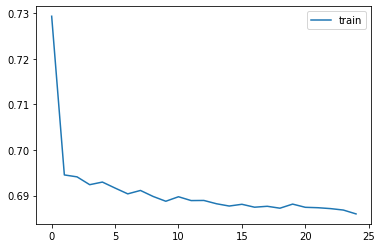

jitter
0.503648
0.1627359795569867
evaluate augmented :  jitter [0.666901171207428, 0.5746302008628845, 0.8243243098258972, 0.5268352627754211]


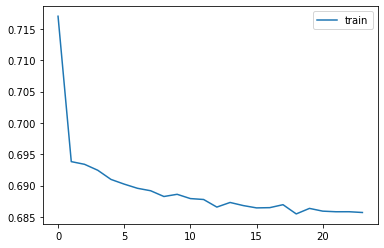

0.503648
0.5021199157953586
evaluate augmented :  jitter [0.6773616075515747, 0.6225907802581787, 0.6476833820343018, 0.5844947695732117]


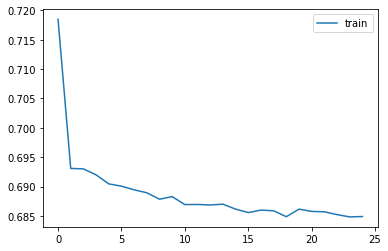

0.503648
0.1378926777756216
evaluate augmented :  jitter [0.670742928981781, 0.5979381203651428, 0.7779922485351562, 0.5471826195716858]


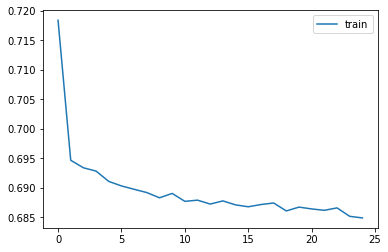

0.503648
0.5262517198981732
evaluate augmented :  jitter [0.6733152866363525, 0.620797872543335, 0.739382266998291, 0.5707898736000061]


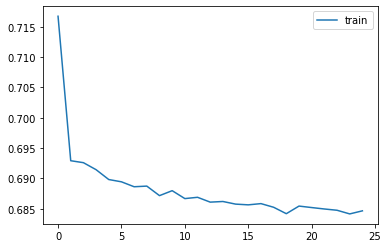

0.503648
0.4885571057818989
evaluate augmented :  jitter [0.6673042178153992, 0.5786643028259277, 0.8194980621337891, 0.5299625396728516]


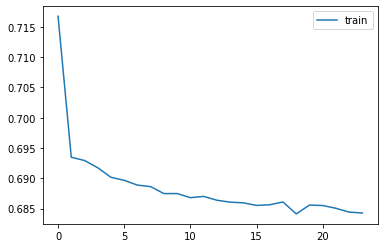

0.503648
0.4873574221460579
evaluate augmented :  jitter [0.6718170046806335, 0.6145226359367371, 0.7586872577667236, 0.5630372762680054]


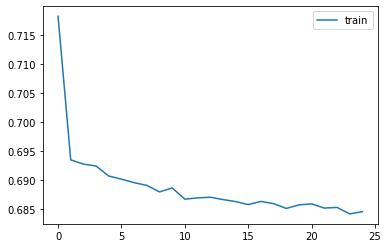

0.503648
0.1803479913288439
evaluate augmented :  jitter [0.6786494255065918, 0.627521276473999, 0.6090733408927917, 0.5969725847244263]


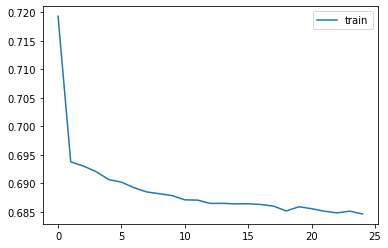

0.503648
0.5261457710478251
evaluate augmented :  jitter [0.6682263612747192, 0.5759748816490173, 0.8175675868988037, 0.5280548334121704]


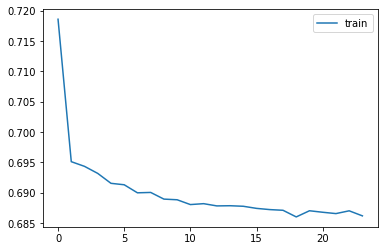

0.503648
0.4993114222447389
evaluate augmented :  jitter [0.6770625710487366, 0.6216943264007568, 0.6891891956329346, 0.5776699185371399]


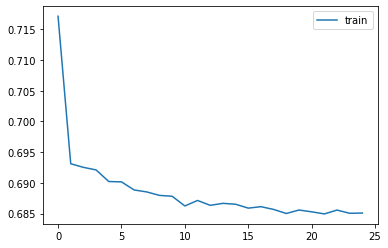

0.503648
0.4975830171512021
evaluate augmented :  jitter [0.6757025718688965, 0.6212460994720459, 0.6611968874931335, 0.5810008645057678]


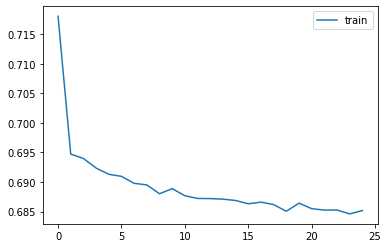

[57.46302008628845, 62.25907802581787, 59.79381203651428, 62.079787254333496, 57.86643028259277, 61.452263593673706, 62.7521276473999, 57.59748816490173, 62.169432640075684, 62.12460994720459]
60.56% (+/- 2.05%)
scale
0.503648
0.8793799217183693
evaluate augmented :  scale [0.675463080406189, 0.6248319149017334, 0.6882239580154419, 0.581092119216919]


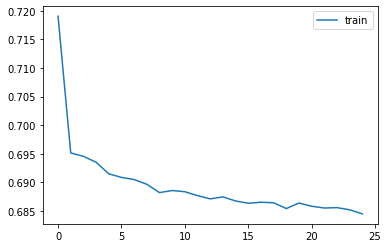

0.503648
0.08934395907530647
evaluate augmented :  scale [0.6827982664108276, 0.6248319149017334, 0.5376448035240173, 0.6087431907653809]


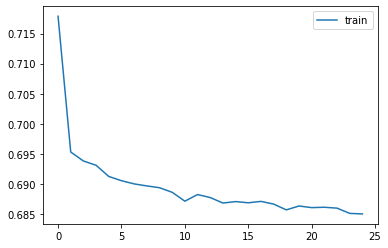

0.503648
0.8795653630150232
evaluate augmented :  scale [0.6645662784576416, 0.5696997046470642, 0.8407335877418518, 0.5228091478347778]


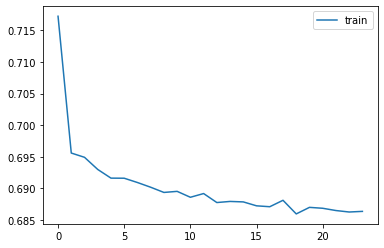

0.503648
0.37619592722046236
evaluate augmented :  scale [0.6790426969528198, 0.6293141841888428, 0.6476833820343018, 0.5922330021858215]


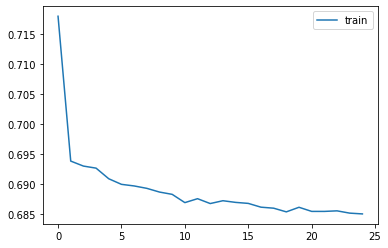

0.503648
0.6903563838865491
evaluate augmented :  scale [0.674748420715332, 0.6261765956878662, 0.6891891956329346, 0.5823817253112793]


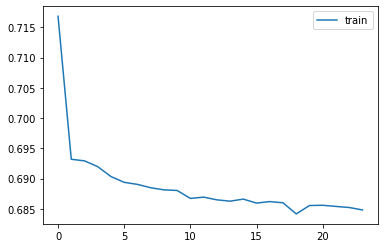

0.503648
0.5272191477155386
evaluate augmented :  scale [0.6754897832870483, 0.6252801418304443, 0.7442085146903992, 0.5745156407356262]


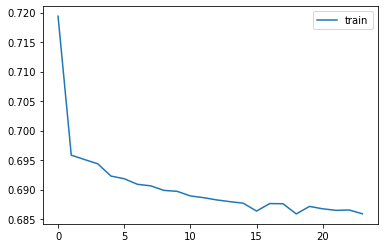

0.503648
0.4995970008647917
evaluate augmented :  scale [0.674708902835846, 0.6163155436515808, 0.7509652376174927, 0.5654069781303406]


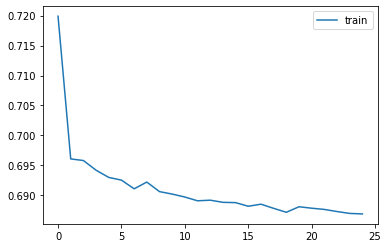

0.503648
0.3281684399932903
evaluate augmented :  scale [0.6773255467414856, 0.6288659572601318, 0.7162162065505981, 0.5815047025680542]


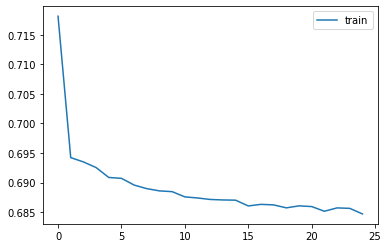

0.503648
0.9452330388740001
evaluate augmented :  scale [0.674057126045227, 0.6225907802581787, 0.7364864945411682, 0.5728228092193604]


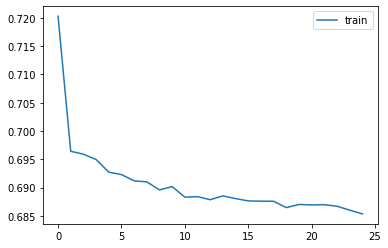

0.503648
0.21607806313419226
evaluate augmented :  scale [0.6684110760688782, 0.5773195624351501, 0.8098455667495728, 0.5293375253677368]


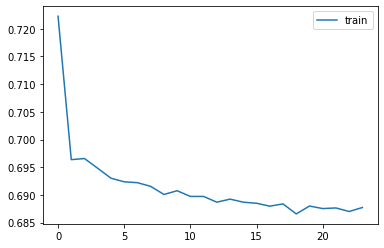

[62.48319149017334, 62.48319149017334, 56.96997046470642, 62.93141841888428, 62.61765956878662, 62.528014183044434, 61.63155436515808, 62.886595726013184, 62.25907802581787, 57.731956243515015]
61.45% (+/- 2.09%)
magWarp
0.503648
0.49817126986045984
evaluate augmented :  magWarp [0.6778485774993896, 0.620797872543335, 0.6245173811912537, 0.5860507488250732]


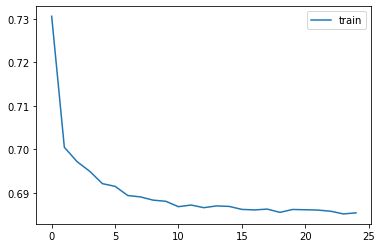

0.503648
0.6623358045968162
evaluate augmented :  magWarp [0.666006863117218, 0.5782160758972168, 0.82722008228302, 0.529339075088501]


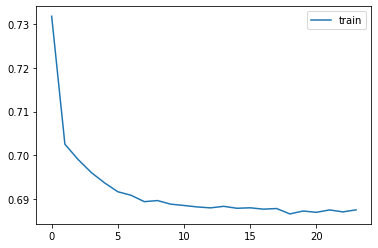

0.503648
0.7793980168313087
evaluate augmented :  magWarp [0.6681159734725952, 0.5701479315757751, 0.82722008228302, 0.5235186219215393]


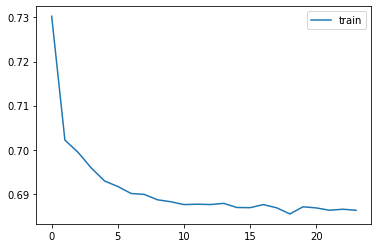

0.503648
0.19808180370804476
evaluate augmented :  magWarp [0.6787596940994263, 0.6234872341156006, 0.6187258958816528, 0.590239405632019]


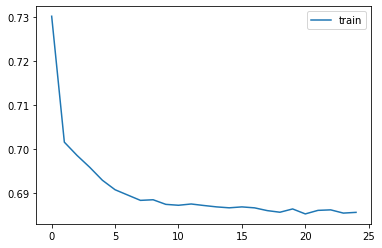

0.503648
0.2327321620427688
evaluate augmented :  magWarp [0.6695952415466309, 0.5974898934364319, 0.80694979429245, 0.5449804663658142]


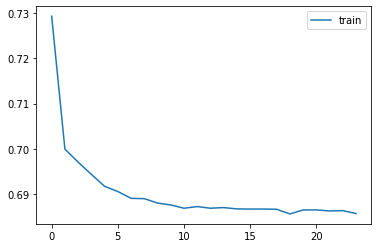

0.503648
0.27674426324356205
evaluate augmented :  magWarp [0.673668384552002, 0.6248319149017334, 0.7413127422332764, 0.5744203329086304]


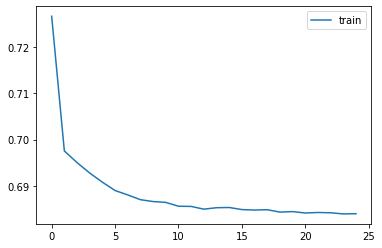

0.503648
0.16355695568853512
evaluate augmented :  magWarp [0.6718112826347351, 0.6216943264007568, 0.7528957724571228, 0.5701754093170166]


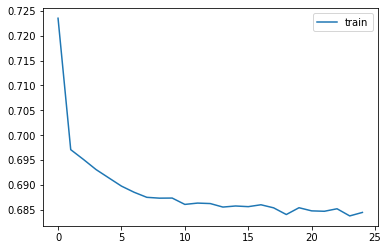

0.503648
0.5385869995775736
evaluate augmented :  magWarp [0.6647922992706299, 0.5652173757553101, 0.8416988253593445, 0.5196662545204163]


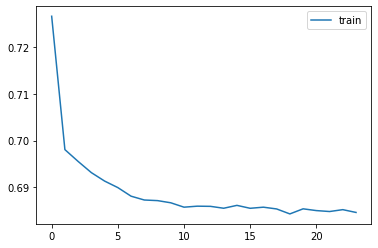

0.503648
0.42143171510399907
evaluate augmented :  magWarp [0.6657599210739136, 0.5723890662193298, 0.8310810923576355, 0.5249999761581421]


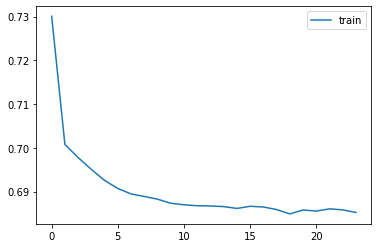

0.503648
0.40631075527882426
evaluate augmented :  magWarp [0.675231397151947, 0.6248319149017334, 0.6940154433250427, 0.5803067088127136]


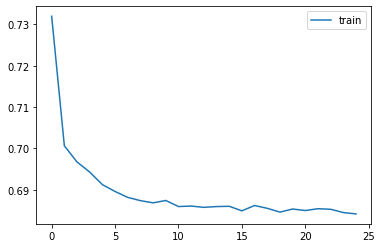

[62.079787254333496, 57.82160758972168, 57.014793157577515, 62.34872341156006, 59.74898934364319, 62.48319149017334, 62.169432640075684, 56.521737575531006, 57.23890662193298, 62.48319149017334]
59.99% (+/- 2.46%)
timeWarp
0.503648
0.115278
evaluate augmented :  timeWarp [0.6653208136558533, 0.5732855200767517, 0.837837815284729, 0.5254237055778503]


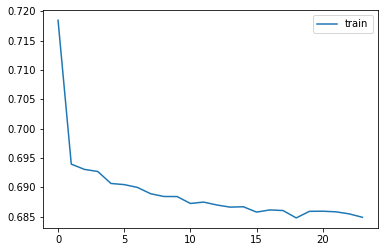

0.503648
0.503648
evaluate augmented :  timeWarp [0.6643496751785278, 0.5750784277915955, 0.8416988253593445, 0.5265700221061707]


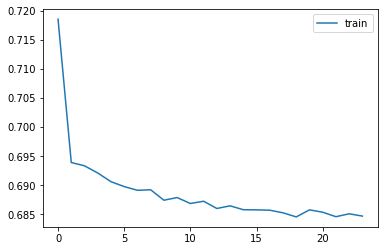

0.503648
0.251317
evaluate augmented :  timeWarp [0.6733537912368774, 0.6181084513664246, 0.7326254844665527, 0.568965494632721]


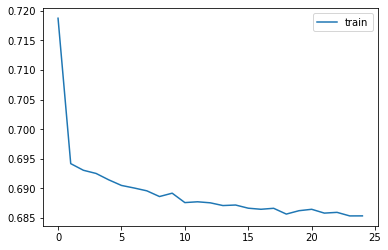

0.503648
0.503648
evaluate augmented :  timeWarp [0.6729860901832581, 0.6190049052238464, 0.7519304752349854, 0.5677842497825623]


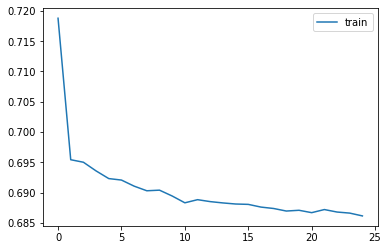

0.503648
0.161656
evaluate augmented :  timeWarp [0.6724071502685547, 0.6216943264007568, 0.7229729890823364, 0.5735068917274475]


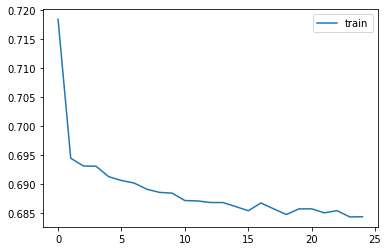

0.503648
0.161656
evaluate augmented :  timeWarp [0.67729252576828, 0.62796950340271, 0.6438223719596863, 0.591312050819397]


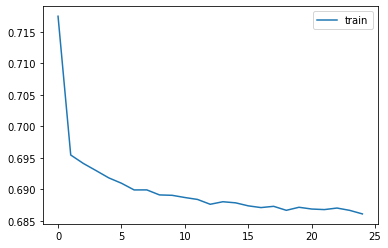

0.503648
0.503648
evaluate augmented :  timeWarp [0.6690786480903625, 0.5791125297546387, 0.8050193190574646, 0.5308720469474792]


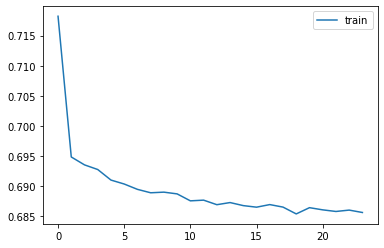

0.503648
0.17676
evaluate augmented :  timeWarp [0.669493556022644, 0.5858359336853027, 0.7944015264511108, 0.5365058779716492]


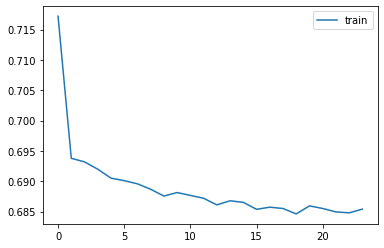

0.503648
0.503648
evaluate augmented :  timeWarp [0.6732878684997559, 0.6172119975090027, 0.7374517321586609, 0.5676077008247375]


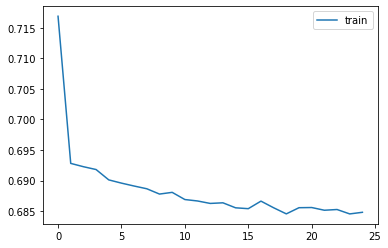

0.503648
0.503648
evaluate augmented :  timeWarp [0.6710753440856934, 0.614970862865448, 0.7519304752349854, 0.564083993434906]


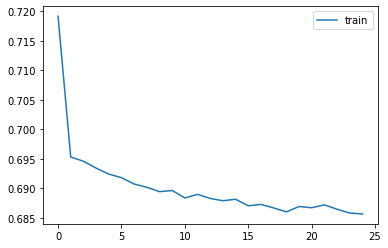

[57.32855200767517, 57.507842779159546, 61.810845136642456, 61.900490522384644, 62.169432640075684, 62.796950340270996, 57.91125297546387, 58.58359336853027, 61.72119975090027, 61.4970862865448]
60.32% (+/- 2.08%)
permutation
0.503648
0.051502
evaluate augmented :  permutation [0.6822574138641357, 0.6257283687591553, 0.6042470932006836, 0.5956231951713562]


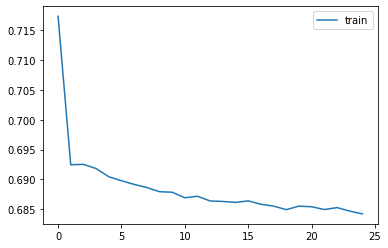

0.503648
0.503648
evaluate augmented :  permutation [0.6711128950119019, 0.6172119975090027, 0.7509652376174927, 0.5662299990653992]


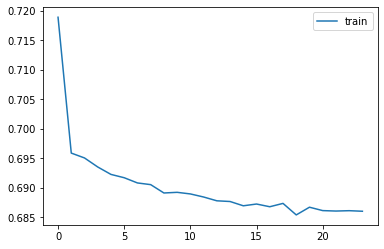

0.503648
0.161656
evaluate augmented :  permutation [0.6706857085227966, 0.5876288414001465, 0.7934362888336182, 0.5379580855369568]


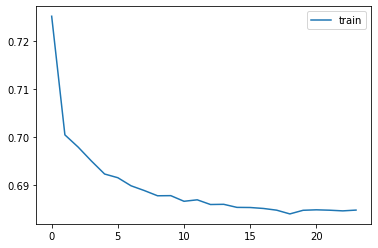

0.503648
0.44729
evaluate augmented :  permutation [0.6696534752845764, 0.5862841606140137, 0.8030887842178345, 0.5364280939102173]


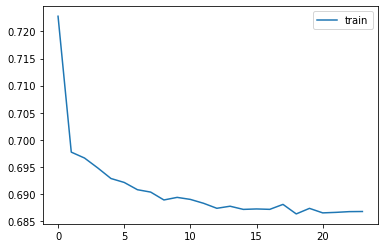

0.503648
0.050221
evaluate augmented :  permutation [0.6785387396812439, 0.6212460994720459, 0.6737451553344727, 0.5792531371116638]


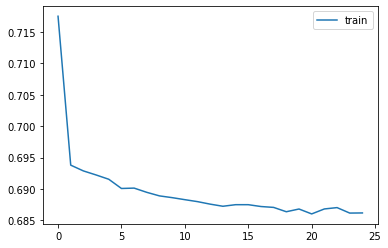

0.503648
0.180602
evaluate augmented :  permutation [0.6718556880950928, 0.5849394798278809, 0.7895752787590027, 0.5360419154167175]


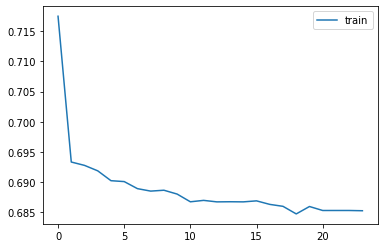

0.503648
0.134491
evaluate augmented :  permutation [0.6645954251289368, 0.5611833333969116, 0.8474903702735901, 0.516774594783783]


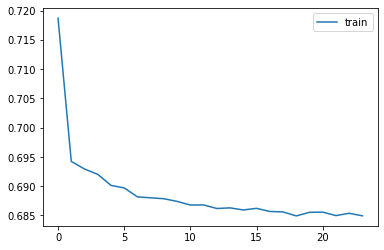

0.503648
0.17676
evaluate augmented :  permutation [0.6698474884033203, 0.5849394798278809, 0.7944015264511108, 0.5358073115348816]


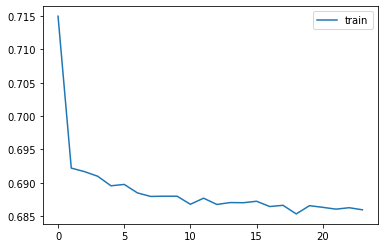

0.503648
0.503648
evaluate augmented :  permutation [0.6663872003555298, 0.5764231085777283, 0.8291505575180054, 0.5279656052589417]


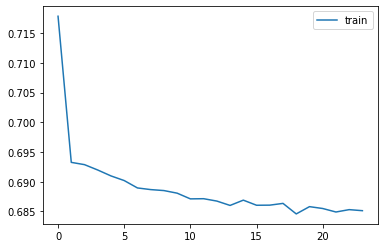

0.503648
0.303566
evaluate augmented :  permutation [0.6764640212059021, 0.6324518322944641, 0.6457529067993164, 0.596256673336029]


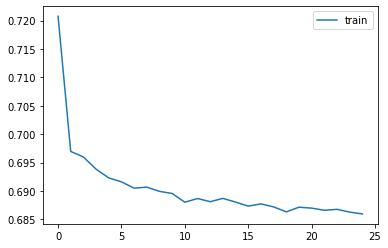

[62.57283687591553, 61.72119975090027, 58.76288414001465, 58.62841606140137, 62.12460994720459, 58.493947982788086, 56.11833333969116, 58.493947982788086, 57.64231085777283, 63.24518322944641]
59.78% (+/- 2.30%)


In [5]:
# for each technique run tec_len times the model to obtain an average of accuracy and fill the csv table with results
techniques = ['jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

arr_eda, arr_bvc,arr_acc,arr_tem = [],[],[],[]
std_arr = []
arr_eda_percentage, arr_bvc_percentage,arr_acc_percentage,arr_tem_percentage = [],[],[],[]
tec_eda, tec_bvc, tec_acc, tec_tem = 0,0,0,0

recall_eda, recall_bvc, recall_acc, recall_tem = [],[],[],[]
precision_eda, precision_bvc, precision_acc, precision_tem = [],[],[],[]

train_set = np.load('train_set_original.npy',  encoding='ASCII')
train_label = np.load('train_label_original.npy',  encoding='ASCII')
test_set = np.load('test_set.npy',  encoding='ASCII')
test_label = np.load('test_label.npy',  encoding='ASCII')
train_label = train_label.reshape(train_label.shape[0], 1)
test_label = test_label.reshape(test_label.shape[0], 1)




# for dim in range(0, 4):
train_set_arr = train_set[0]
test_set_arr = test_set[0]

model = model_network()

# ORIGINAL SET
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(train_set_arr, train_label, epochs=25, batch_size= 128, shuffle=True, verbose=0, callbacks=[callback])
scores1 = model.evaluate(test_set_arr, test_label, verbose=0)
print("evaluate original: ",scores1)
tec_eda = scores1[1]
recall_original = scores1[2]
precision_original = scores1[3]

recall_eda.append(recall_original)
precision_eda.append(precision_original)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()
            
# --------------------------------------------------------------------


for technique in techniques:
    print(technique)
    avg_tec_eda = []
    
    recall_original, precision_original, recall_aug, precision_aug = 0,0,0,0
    cvscores = []
    
    tec_len = 10
    
# loop tec_len times to get the average of a tecnique
    for avg_t in range(0, tec_len):
        train_set = np.load('train_set_original.npy',  encoding='ASCII')
        train_label = np.load('train_label_original.npy',  encoding='ASCII')
        test_set = np.load('test_set.npy',  encoding='ASCII')
        test_label = np.load('test_label.npy',  encoding='ASCII')
        train_label = train_label.reshape(train_label.shape[0], 1)
        test_label = test_label.reshape(test_label.shape[0], 1)

        
        train_set_arr_augment, label_set_augmented = augment_data(train_set[0], train_label, technique)
        
        test_set_arr = test_set[0]
        model = model_network()

        # AUGMENTATION
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        history = model.fit(train_set_arr_augment, label_set_augmented, epochs=25, batch_size= 128, shuffle=True,verbose=0, callbacks = [callback])
        scores2 = model.evaluate(test_set_arr, test_label,verbose=0)
        #     --------------------------------------------------------------------
        print("evaluate augmented : ", technique, scores2)

        avg_tec_eda.append(scores2[1])
#         std_arr.append(scores2[1])
        cvscores.append(scores2[1] * 100)
        recall_aug += scores2[2]
        precision_aug += scores2[3]

        pyplot.plot(history.history['loss'], label='train')
        pyplot.legend()
        pyplot.show()
 

    arr_eda.append(np.mean(avg_tec_eda))
    recall_eda.append(recall_aug/tec_len)
    precision_eda.append(precision_aug/tec_len)
    print(cvscores)
    print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    std_arr.append(np.std(cvscores))

    arr_eda_percentage.append(round((np.mean(avg_tec_eda) - tec_eda) * 100, 4))


# insert eda and baseline
arr_eda.insert(0, tec_eda)
std_arr.insert(0, 0)
# recall_eda.insert(0, recall_original)
# precision_eda.insert(0, precision_original)

arr_eda.insert(0, 'EDA')
recall_eda.insert(0, 'RECALL')
precision_eda.insert(0, 'PRECISION')
std_arr.insert(0, 'STD')

# print("STD: ", std)
header = ['sensor', 'baseline', 'jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

with open('table_accuracy.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerow(arr_eda)
    writer.writerow(recall_eda)
    writer.writerow(precision_eda)
    writer.writerow(std_arr)
    writer.writerow([])
    arr_eda_percentage.insert(0, 0)
    arr_eda_percentage.insert(0, 'EDA')
    writer.writerow(arr_eda_percentage)


